In [90]:
from ucimlrepo import fetch_ucirepo
import polars as pl
import polars.selectors as cs
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

heart_disease = fetch_ucirepo(id=45)
raw = pl.from_pandas(heart_disease.data.original)

In [91]:
OUTLIER_THRESHOLD = 2  # Standard deviations from the mean

data = raw.drop_nulls()
data = data.with_columns(
    (pl.col("num") >= 1).cast(pl.Int64).alias("num"),
    cs.exclude("sex", "fbs", "exang", "num").map_batches(lambda col: (col - col.mean()) / col.std()),
)
data = data.filter(pl.all_horizontal(cs.exclude("sex", "fbs", "exang", "num").abs() <= OUTLIER_THRESHOLD))
data.describe()

statistic,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-0.094678,0.664975,0.135865,-0.196795,-0.03153,0.096447,-0.027228,0.11637,0.28934,-0.231774,-0.244128,-0.201773,-0.104569,0.406091
"""std""",0.913207,0.473202,0.812672,0.813378,0.804878,0.295955,1.004644,0.86456,0.454611,0.798941,0.807098,0.750061,0.98252,0.492353
"""min""",-1.938409,0.0,-1.200433,-1.784268,-1.891437,0.0,-1.001728,-1.944041,0.0,-0.905184,-0.974938,-0.72076,-0.892713,0.0
"""25%""",-0.833404,0.0,-0.164013,-0.65832,-0.679843,0.0,-1.001728,-0.418425,0.0,-0.905184,-0.974938,-0.72076,-0.892713,0.0
"""50%""",-0.059901,1.0,-0.164013,-0.095345,-0.083661,0.0,-1.001728,0.278999,0.0,-0.562167,-0.974938,-0.72076,-0.892713,0.0
"""75%""",0.603102,1.0,0.872408,0.467629,0.454826,0.0,1.008496,0.802067,1.0,0.295376,0.642696,0.344243,1.170601,1.0
"""max""",1.818607,1.0,0.872408,1.593577,1.820274,1.0,1.008496,1.673847,1.0,1.838953,0.642696,1.409246,1.170601,1.0


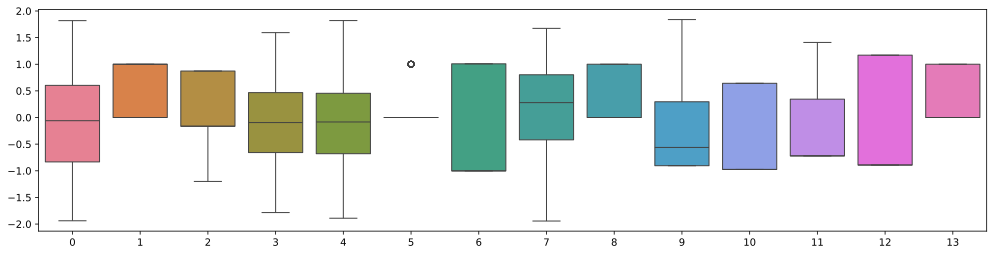

In [92]:
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
plt.show()

In [93]:
batch_size = 32
X = data[:, :-1].to_torch().float()
y = data[:, -1].to_torch().float()[:, None]  # make it a column vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)
print(X.shape, y.shape)

torch.Size([197, 13]) torch.Size([197, 1])


# Neural Network

In [98]:
class HeartDiseaseNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input = nn.Linear(input_size, 32)
        self.fc1 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.output(x)


In [99]:
# test the model on a bit of data
net = HeartDiseaseNN(13)

X, y = next(iter(train_loader))
y_hat = net(X)
print(y_hat.shape, y.shape)

# test the loss function
lossfun = nn.BCEWithLogitsLoss()
lossfun(y_hat, y)

torch.Size([32, 1]) torch.Size([32, 1])


tensor(0.6583, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [100]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

net = HeartDiseaseNN(13)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)
lossfun = nn.BCEWithLogitsLoss()
num_epochs = 500

train_loss = torch.zeros(num_epochs)
test_loss = torch.zeros(num_epochs)
train_acc = torch.zeros(num_epochs)
test_acc = torch.zeros(num_epochs)

best_test_acc = 0.0
best_model_path = 'best_model.pt'

for epoch_i in tqdm(range(num_epochs), desc="Training"):
    batch_loss = []

    net.train()
    for X, y in train_loader:
        y_hat = net(X)
        loss = lossfun(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())

        y_pred = torch.sigmoid(y_hat) >= 0.5
        train_acc[epoch_i] = 100 * (y_pred == y).float().mean().item()

    train_loss[epoch_i] = torch.tensor(batch_loss).mean()

    net.eval()
    with torch.no_grad():
        X, y = next(iter(test_loader))
        y_hat = net(X)
        loss = lossfun(y_hat, y)
        test_loss[epoch_i] = loss.item()

        predictions = (torch.sigmoid(y_hat) >= 0.5).float()
        test_acc[epoch_i] = 100 * (predictions == y).float().mean().item()

        # Save best model
        if test_acc[epoch_i] > best_test_acc:
            best_test_acc = test_acc[epoch_i].item()
            torch.save(net.state_dict(), best_model_path)
            print(f"Saved new best model at epoch {epoch_i+1} with test acc: {best_test_acc:.2f}%")

print(f"Highest test accuracy: {best_test_acc:.2f}%")


Training:   4%|▍         | 20/500 [00:00<00:05, 95.99it/s]

Saved new best model at epoch 1 with test acc: 57.50%


Training:   9%|▉         | 47/500 [00:00<00:03, 120.68it/s]

Saved new best model at epoch 22 with test acc: 60.00%
Saved new best model at epoch 35 with test acc: 62.50%


Training:  15%|█▌        | 75/500 [00:00<00:03, 132.00it/s]

Saved new best model at epoch 50 with test acc: 65.00%
Saved new best model at epoch 63 with test acc: 67.50%
Saved new best model at epoch 72 with test acc: 70.00%
Saved new best model at epoch 79 with test acc: 72.50%


Training:  24%|██▍       | 121/500 [00:00<00:02, 142.76it/s]

Saved new best model at epoch 93 with test acc: 75.00%
Saved new best model at epoch 98 with test acc: 77.50%
Saved new best model at epoch 103 with test acc: 80.00%


Training:  30%|███       | 151/500 [00:01<00:02, 144.47it/s]

Saved new best model at epoch 122 with test acc: 82.50%
Saved new best model at epoch 126 with test acc: 85.00%
Saved new best model at epoch 142 with test acc: 87.50%


Training:  40%|███▉      | 199/500 [00:01<00:01, 152.92it/s]

Saved new best model at epoch 171 with test acc: 90.00%


Training: 100%|██████████| 500/500 [00:03<00:00, 138.23it/s]

Highest test accuracy: 90.00%


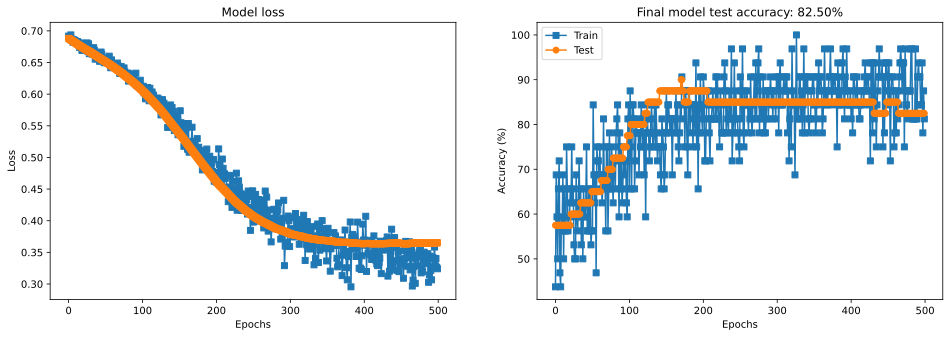

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, "s-", label="Train")
ax[0].plot(test_loss, "s-", label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")

ax[1].plot(train_acc, "s-", label="Train")
ax[1].plot(test_acc, "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final model test accuracy: {test_acc[-1]:.2f}%")
ax[1].legend()

plt.show()